# 📊 MiniProject 2: Regularization and Model Evaluation

**Course:** COMP 551 - Applied Machine Learning

**Institution:** McGill University  

**Group:** Giane Mayumi Galhard (51261276747), Daria Goptsii (261275056), Yixuan Qin (261010963)

**Term:** Fall 2025

---

This project aims to help us with synthetic data to explore the details of linear regression, bias-variance trade-off, regularization with cross-validation and effect of L1 and L2 regularization on loss.

---

## Setup

Setting constants, importing libraries, packages and modules.

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import itertools

from sklearn.model_selection import train_test_split

In [ ]:
# Constants for L1 and L2
L1 = "L1"
L2 = "L2"

## Implementations

In [ ]:
class GradientDescent:

    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 0 #!!!!!!!!!!!!! conventional zero-based counter (was t=1)
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

class LinearRegression:
    def __init__(self, add_bias=True, type_reg=L1, lambda_reg=0):
        self.add_bias = add_bias
        self.lambda_reg = lambda_reg
        self.type_reg = type_reg
        pass

    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):
            yh =  x @ w
            N, D = x.shape
            #grad = .5*np.dot(yh - y, x)/N #!!!!!!!!wrong formula gradient term should be (1/N) * X.T @ (Xw - y)
            grad = (x.T @ (x @ w - y)) / N
            if self.lambda_reg != 0:
              if self.type_reg==L1:
                grad[:-1] += self.lambda_reg * np.sign(w[:-1]) #!!!!!!!! was mistake in regularization
              elif self.type_reg==L2:
                grad[:-1] += self.lambda_reg * w[:-1] #!!!!!!!!!!!! was mistake in regularization. # λ/2 ‖w‖² convention
            return grad
        w0 = np.zeros(D)
        self.w = optimizer.run(gradient, x, y, w0)
        return self

    def predict(self, x):

        if x.ndim == 1: #ADC
            x = x[:, None]
        N = x.shape[0] #ADC
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])

        yh = x@self.w
        return yh

In [ ]:
def cross_validate(n, n_folds=10):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

In [ ]:
def sse(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    return float(np.sum((y_true - y_pred)**2))

In [ ]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

#Task 1

> In this task, you will generate synthetic data and fit a linear regression model using non-linear basis functions. The goal of this task is to explore how model complexity affects performance, helping you understand the transition from
underfitting to overfitting.

In [ ]:

# ---------------- Common true function ----------------
def f_true(x):
    x = np.asarray(x, dtype=float)
    return (np.log(x + 1.0))*np.cos(x) + np.sin(2.0*x)

# ---------------- Basis helpers (Gaussian) ----------------
def gaussian_centers(xmin, xmax, D):
    if D == 0:
        return np.empty((0,), dtype=float)
    if D == 1:
        return np.array([0.5*(xmin + xmax)], dtype=float)
    return np.linspace(xmin, xmax, D)

def gaussian_design(X, D, sigma=1.0, centers=None):
    X = np.asarray(X, dtype=float).reshape(-1, 1)
    xmin, xmax = float(X.min()), float(X.max())
    if D == 0:
        return np.zeros((X.shape[0], 0), dtype=float), centers
    if centers is None:
        centers = gaussian_centers(xmin, xmax, D)
    diffs = X - centers[None, :]
    Phi = np.exp(-(diffs**2) / (sigma**2))
    return Phi, centers

# ---------------- Basis helpers (Sigmoid) ----------------
def sigmoid_centers(xmin, xmax, D):
    if D == 0:
        return np.empty((0,), dtype=float)
    if D == 1:
        return np.array([0.5*(xmin + xmax)], dtype=float)
    return np.linspace(xmin, xmax, D)

def sigmoid_design(X, D, scale=None, alpha=0.6):
    """
    Phi: (N,D), phi_i(x) = 1/(1+exp(-(x - mu_i)/scale)).
    Returns (Phi, centers, scale_used).
    """
    X = np.asarray(X, dtype=float).reshape(-1, 1)
    xmin, xmax = float(X.min()), float(X.max())
    mus = sigmoid_centers(xmin, xmax, D)

    if D == 0:
        return np.zeros((X.shape[0], 0), dtype=float), mus, None

    if scale is None:
        span = xmax - xmin if xmax > xmin else 1.0
        avg_spacing = span / max(D, 1)
        scale = alpha * avg_spacing

    diffs = (X - mus[None, :]) / float(scale)
    Phi = 1.0 / (1.0 + np.exp(-diffs))
    return Phi, mus, scale

def simple_train_test_split(X, y, test_size=0.2, seed=0):
    X = np.asarray(X); y = np.asarray(y)
    n = len(X)
    rng = np.random.default_rng(seed)
    perm = rng.permutation(n)
    n_test = int(round(n * test_size))
    te = perm[:n_test]
    tr = perm[n_test:]
    return X[tr], X[te], y[tr], y[te]

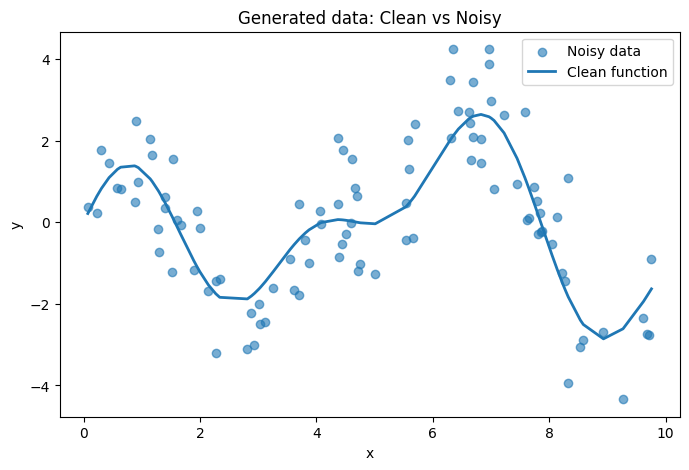

In [ ]:
rng_G1 = np.random.default_rng(42)
G1_n = 100
G1_X = rng_G1.uniform(0.0, 10.0, G1_n)
G1_y_clean = f_true(G1_X)
G1_y_noisy = G1_y_clean + rng_G1.normal(0.0, 1.0, G1_n)

plt.figure(figsize=(8,5))
plt.scatter(G1_X, G1_y_noisy, alpha=0.6, label="Noisy data")
order = np.argsort(G1_X)
plt.plot(G1_X[order], G1_y_clean[order], linewidth=2, label="Clean function")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Generated data: Clean vs Noisy")
plt.legend(); plt.show()


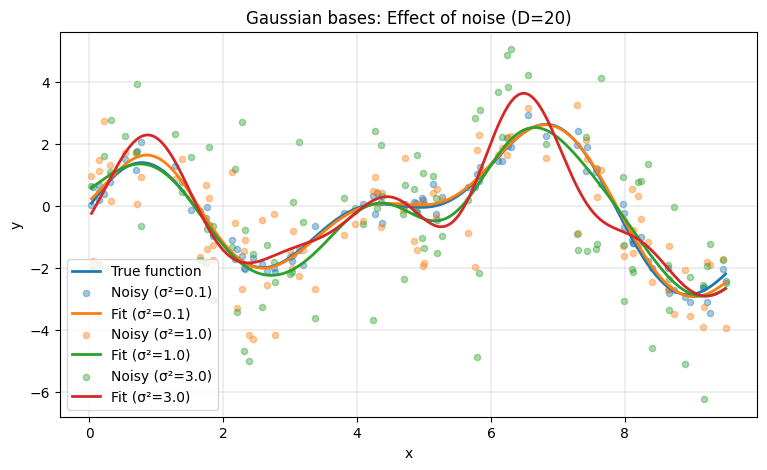

In [ ]:
rng_G2 = np.random.default_rng(123)
G2_n = 100
G2_X = rng_G2.uniform(0.0, 10.0, G2_n)
G2_xs = np.linspace(float(G2_X.min()), float(G2_X.max()), 400)
G2_y_true_dense = f_true(G2_xs)

G2_noise_vars = [0.1, 1.0, 3.0]
G2_D = 20
G2_gd = GradientDescent(learning_rate=5e-2, max_iters=20000, epsilon=1e-7)

plt.figure(figsize=(9,5))
plt.plot(G2_xs, G2_y_true_dense, linewidth=2, label="True function")

for nv in G2_noise_vars:
    y_noisy = f_true(G2_X) + rng_G2.normal(0.0, np.sqrt(nv), G2_n)
    Phi_tr, _ = gaussian_design(G2_X, D=G2_D, sigma=1.0)
    model = LinearRegression(add_bias=True)
    model.fit(Phi_tr, y_noisy, G2_gd)

    Phi_dx, _ = gaussian_design(G2_xs, D=G2_D, sigma=1.0)
    y_fit = model.predict(Phi_dx)

    plt.scatter(G2_X, y_noisy, s=20, alpha=0.4, label=f"Noisy (σ²={nv})")
    plt.plot(G2_xs, y_fit, linewidth=2, label=f"Fit (σ²={nv})")

plt.title(f"Gaussian bases: Effect of noise (D={G2_D})")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.grid(True, linewidth=0.3)
plt.show()


D	Test MSE
0	2.7500
1	2.6317
2	1.5367
3	1.5963
4	1.3382
5	1.3275
6	1.3708
7	1.5888
8	1.6854
9	1.5683
10	1.5753
11	1.6169
12	1.6478
13	1.6266
14	1.6343
15	1.6316
16	1.6323
17	1.6325
18	1.6328
19	1.6332
20	1.6336
21	1.6340
22	1.6343
23	1.6347
24	1.6351
25	1.6354
26	1.6357
27	1.6361
28	1.6364
29	1.6367
30	1.6369
31	1.6372
32	1.6374
33	1.6377
34	1.6379
35	1.6381
36	1.6383
37	1.6385
38	1.6387
39	1.6389
40	1.6391
41	1.6392
42	1.6394
43	1.6395
44	1.6397
45	1.6398


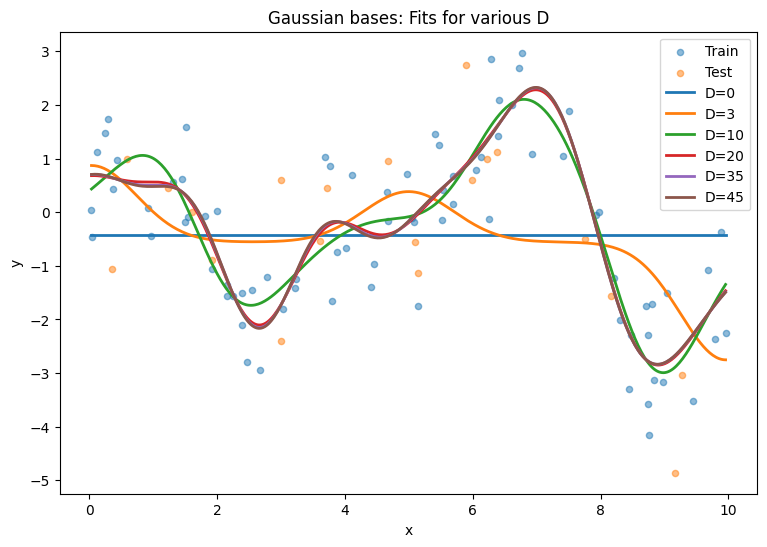

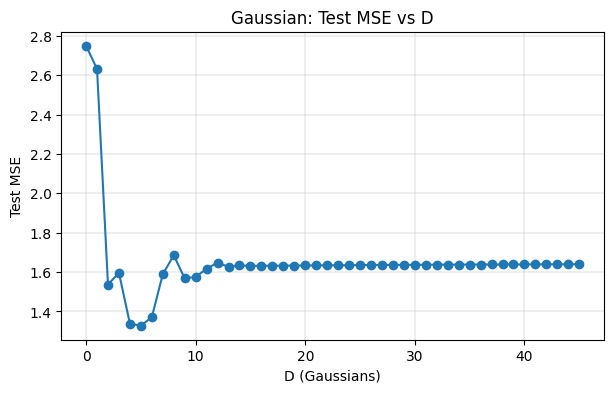

In [ ]:
rng_G3 = np.random.default_rng(7)
G3_n = 100
G3_X = rng_G3.uniform(0.0, 10.0, G3_n)
G3_y = f_true(G3_X) + rng_G3.normal(0.0, 1.0, G3_n)

G3_Xtr, G3_Xte, G3_ytr, G3_yte = simple_train_test_split(G3_X, G3_y, test_size=0.2, seed=42)

G3_Ds = list(range(0, 46))
G3_gd = GradientDescent(learning_rate=5e-2, max_iters=20000, epsilon=1e-7)

G3_results = []
G3_fits = {}
xmin, xmax = float(G3_X.min()), float(G3_X.max())

for D in G3_Ds:
    Phi_tr, _ = gaussian_design(G3_Xtr, D=D, sigma=1.0)
    Phi_te, _ = gaussian_design(G3_Xte, D=D, sigma=1.0)

    model = LinearRegression(add_bias=True)
    model.fit(Phi_tr, G3_ytr, G3_gd)

    y_hat_te = model.predict(Phi_te)
    G3_results.append((D, mean_squared_error(G3_yte, y_hat_te)))

    xs = np.linspace(xmin, xmax, 400)
    Phi_xs, _ = gaussian_design(xs, D=D, sigma=1.0)
    G3_fits[D] = (xs, model.predict(Phi_xs))

print("D\tTest MSE")
for D, mse in G3_results:
    print(f"{D}\t{mse:.4f}")

# Show a few fits
to_show = [0, 3, 10, 20, 35, 45]
plt.figure(figsize=(9,6))
plt.scatter(G3_Xtr, G3_ytr, s=20, alpha=0.5, label="Train")
plt.scatter(G3_Xte, G3_yte, s=20, alpha=0.5, label="Test")
for D in to_show:
    xs_fit, ys_fit = G3_fits[D]
    plt.plot(xs_fit, ys_fit, linewidth=2, label=f"D={D}")
plt.title("Gaussian bases: Fits for various D")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

# MSE vs D
Ds_arr = np.array([d for d, _ in G3_results])
MSE_arr = np.array([m for _, m in G3_results])
plt.figure(figsize=(7,4))
plt.plot(Ds_arr, MSE_arr, marker="o")
plt.xlabel("D (Gaussians)"); plt.ylabel("Test MSE")
plt.title("Gaussian: Test MSE vs D")
plt.grid(True, linewidth=0.3); plt.show()


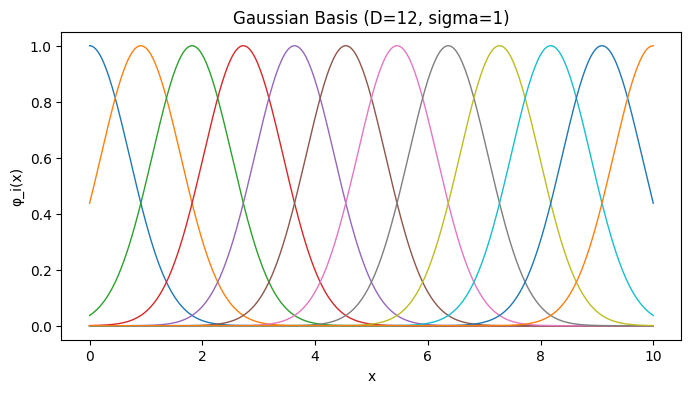

In [ ]:
G4_D = 12
G4_xs = np.linspace(0.0, 10.0, 400)
G4_Phi, G4_mus = gaussian_design(G4_xs, D=G4_D, sigma=1.0)

plt.figure(figsize=(8,4))
for i in range(G4_Phi.shape[1]):
    plt.plot(G4_xs, G4_Phi[:, i], linewidth=1)
plt.title(f"Gaussian Basis (D={G4_D}, sigma=1)")
plt.xlabel("x"); plt.ylabel("φ_i(x)")
plt.show()


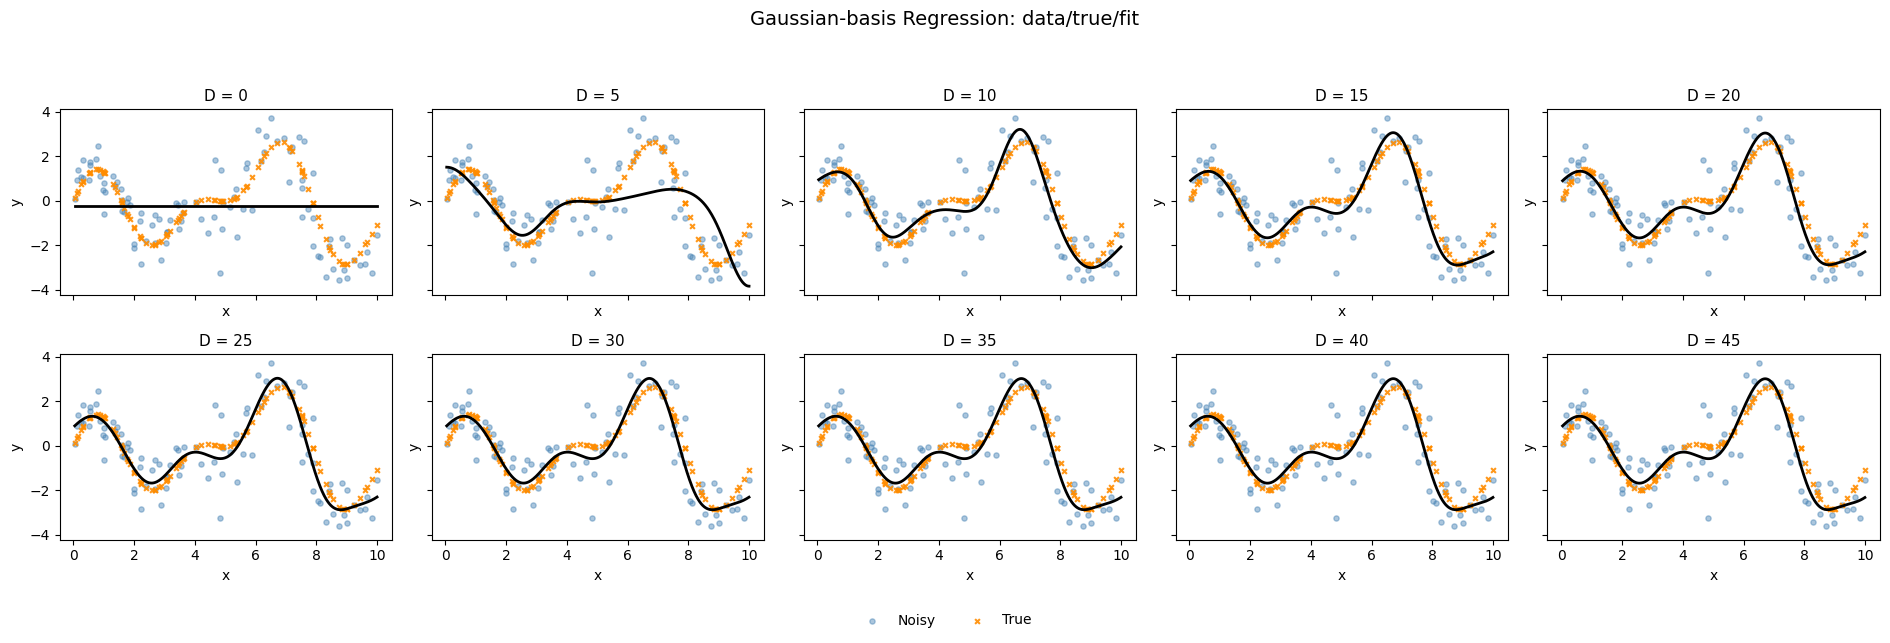

In [ ]:
rng_G5 = np.random.default_rng(314)
G5_n = 100
G5_X = rng_G5.uniform(0.0, 10.0, G5_n)
G5_y = f_true(G5_X) + rng_G5.normal(0.0, 1.0, G5_n)

G5_Ds = list(range(0, 46, 5))
G5_gd = GradientDescent(learning_rate=5e-2, max_iters=20000, epsilon=1e-7)

xs_dense = np.linspace(float(G5_X.min()), float(G5_X.max()), 600)
y_true_dense = f_true(xs_dense)
y_true_at_data = f_true(G5_X)

nD = len(G5_Ds); n_cols = 5; n_rows = int(np.ceil(nD / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.8*n_cols, 3.0*n_rows), sharex=True, sharey=True)
axes = np.asarray(axes).ravel()

for ax, D in zip(axes, G5_Ds):
    Phi, _ = gaussian_design(G5_X, D=D, sigma=1.0)
    Phi_dx, _ = gaussian_design(xs_dense, D=D, sigma=1.0)
    model = LinearRegression(add_bias=True)
    model.fit(Phi, G5_y, G5_gd)
    y_fit = model.predict(Phi_dx)

    ax.scatter(G5_X, G5_y, s=14, alpha=0.45, label="Noisy", color="steelblue")
    ax.scatter(G5_X, y_true_at_data, s=12, alpha=0.9, marker='x', label="True", color="darkorange")
    ax.plot(xs_dense, y_fit, linewidth=2, color="black")
    ax.set_title(f"D = {D}", fontsize=11)
    ax.set_xlabel("x"); ax.set_ylabel("y")

for j in range(len(G5_Ds), len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=10, bbox_to_anchor=(0.5, -0.02))
fig.suptitle("Gaussian-basis Regression: data/true/fit", fontsize=14, y=1.03)
plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()


In [ ]:
rng_G6 = np.random.default_rng(2718)
G6_n = 100
G6_X = rng_G6.uniform(0.0, 10.0, G6_n)
G6_y = f_true(G6_X) + rng_G6.normal(0.0, 1.0, G6_n)

G6_k = 10
G6_Ds = list(range(0, 46, 5))
G6_gd = GradientDescent(learning_rate=5e-2, max_iters=20000, epsilon=1e-7)

G6_rows = []
for D in G6_Ds:
    tr_sse, val_sse = [], []
    for tr_idx, val_idx in cross_validate(len(G6_X), G6_k):
        Xtr, Xval = G6_X[tr_idx], G6_X[val_idx]
        ytr, yval = G6_y[tr_idx], G6_y[val_idx]

        Phi_tr, _  = gaussian_design(Xtr, D=D, sigma=1.0)
        Phi_val, _ = gaussian_design(Xval, D=D, sigma=1.0)

        model = LinearRegression(add_bias=True)
        model.fit(Phi_tr, ytr, G6_gd)

        yhat_tr  = model.predict(Phi_tr)
        yhat_val = model.predict(Phi_val)
        tr_sse.append(sse(ytr,  yhat_tr))
        val_sse.append(sse(yval, yhat_val))

    tr_sse = np.array(tr_sse, dtype=float)
    val_sse = np.array(val_sse, dtype=float)
    mean_tr = float(tr_sse.mean())
    mean_val = float(val_sse.mean())
    sd_val  = float(np.std(val_sse, ddof=1))
    se_val  = sd_val / np.sqrt(G6_k)
    G6_rows.append((D, mean_tr, mean_val, sd_val, se_val))

G6_rows = sorted(G6_rows, key=lambda t: t[0])
hdr = f"{'D':>3}  {'SSE_train':>12}  {'SSE_val':>12}  {'±1 SE':>9}  {'±1 SD':>9}"
print(hdr); print("-"*len(hdr))
for D, m_tr, m_val, sd_val, se_val in G6_rows:
    print(f"{D:>3d}  {m_tr:12.2f}  {m_val:12.2f}  {se_val:9.2f}  {sd_val:9.2f}")

best_D, _, best_val, best_sd, best_se = min(G6_rows, key=lambda t: t[2])
print(f"\nBest D (min mean SSE_val): {best_D} | SSE_val = {best_val:.2f} (±{best_sd:.2f} SD, ±{best_se:.2f} SE)")
thr_1SE = best_val + best_se
eligible = [D for (D, _, m_val, _, _) in G6_rows if m_val <= thr_1SE]
one_se_D = min(eligible) if eligible else best_D
print(f"1-SE rule -> choose D = {one_se_D} (threshold = {thr_1SE:.2f})")


threshold_1SD = best_val + best_sd
eligible_1SD = [D for (D, _, m_val, _, _) in G6_rows if m_val <= threshold_1SD]
one_sd_D = min(eligible_1SD) if eligible_1SD else best_D
print(f"1-SD rule -> choose D = {one_sd_D} (threshold = {threshold_1SD:.2f})")


  D     SSE_train       SSE_val      ±1 SE      ±1 SD
-----------------------------------------------------
  0        309.68         34.94       2.54       8.04
  5        190.80         25.62       7.07      22.35
 10         89.20         26.78       8.25      26.10
 15         86.68         26.55       8.35      26.39
 20         86.48         26.59       8.37      26.48
 25         86.37         26.61       8.38      26.49
 30         86.27         26.62       8.38      26.50
 35         86.20         26.63       8.38      26.50
 40         86.13         26.63       8.38      26.50
 45         86.07         26.63       8.38      26.51

Best D (min mean SSE_val): 5 | SSE_val = 25.62 (±22.35 SD, ±7.07 SE)
1-SE rule -> choose D = 5 (threshold = 32.69)
1-SD rule -> choose D = 0 (threshold = 47.97)


In [ ]:
rng_S1 = np.random.default_rng(1001)
S1_n = 100
S1_X = rng_S1.uniform(0.0, 10.0, S1_n)
S1_y = f_true(S1_X) + rng_S1.normal(0.0, 1.0, S1_n)


D	Test MSE
0	2.4713
1	2.4168
2	2.3879
3	1.5025
4	1.3621
5	1.3633
6	1.3505
7	1.3934
8	1.3943
9	1.2731
10	1.1622
11	1.0602
12	0.9889
13	0.9564
14	0.9481
15	0.9640
16	0.9878
17	1.0182
18	1.0513
19	1.0765
20	1.0994
21	1.1148
22	1.1290
23	1.1400
24	1.1510
25	1.1576
26	1.1682
27	1.1781
28	1.1868
29	1.2002
30	1.2112
31	1.2253
32	1.2422
33	1.2599
34	1.2785
35	1.2998
36	1.3242
37	1.3463
38	1.3720
39	1.3980
40	1.4235
41	1.4510
42	1.4786
43	1.5052
44	1.5335
45	1.5608


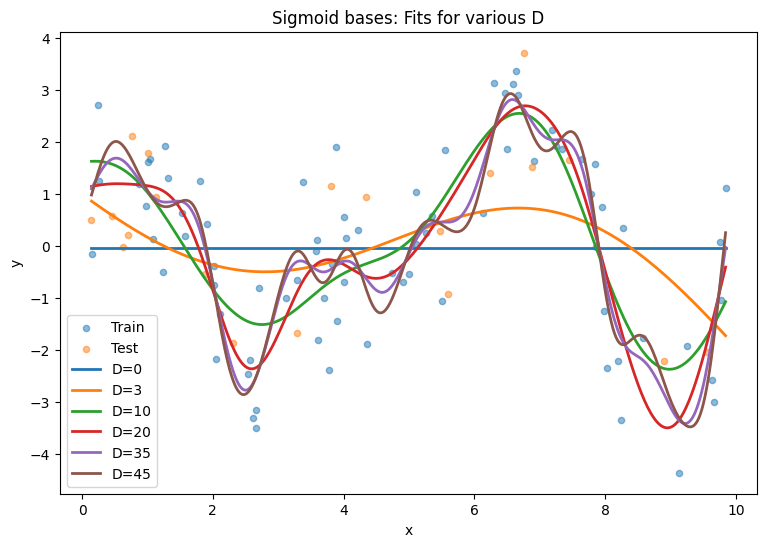

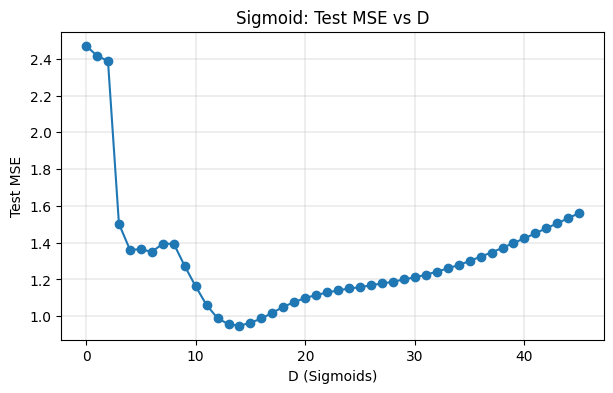

In [ ]:
S2_Xtr, S2_Xte, S2_ytr, S2_yte = simple_train_test_split(S1_X, S1_y, test_size=0.2, seed=42)

S2_Ds = list(range(0, 46))
S2_gd = GradientDescent(learning_rate=5e-2, max_iters=20000, epsilon=1e-7)

S2_results = {}
S2_fits = {}
xmin, xmax = float(S1_X.min()), float(S1_X.max())

for D in S2_Ds:
    Phi_tr, _, used_scale = sigmoid_design(S2_Xtr, D=D, scale=None, alpha=0.6)
    Phi_te, _, _          = sigmoid_design(S2_Xte, D=D, scale=used_scale, alpha=0.6)

    model = LinearRegression(add_bias=True)
    model.fit(Phi_tr, S2_ytr, S2_gd)

    y_hat_te = model.predict(Phi_te)
    S2_results[D] = mean_squared_error(S2_yte, y_hat_te)

    xs = np.linspace(xmin, xmax, 400)
    Phi_xs, _, _ = sigmoid_design(xs, D=D, scale=used_scale, alpha=0.6)
    S2_fits[D] = (xs, model.predict(Phi_xs))

print("D\tTest MSE")
for D in S2_Ds:
    print(f"{D}\t{S2_results[D]:.4f}")

# Show a few fits
to_show = [0, 3, 10, 20, 35, 45]
plt.figure(figsize=(9,6))
plt.scatter(S2_Xtr, S2_ytr, s=20, alpha=0.5, label="Train")
plt.scatter(S2_Xte, S2_yte, s=20, alpha=0.5, label="Test")
for D in to_show:
    xs_fit, ys_fit = S2_fits[D]
    plt.plot(xs_fit, ys_fit, linewidth=2, label=f"D={D}")
plt.title("Sigmoid bases: Fits for various D")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

# MSE vs D
Ds_arr = np.array(list(S2_results.keys()))
MSE_arr = np.array([S2_results[d] for d in Ds_arr])
plt.figure(figsize=(7,4))
plt.plot(Ds_arr, MSE_arr, marker="o")
plt.xlabel("D (Sigmoids)"); plt.ylabel("Test MSE")
plt.title("Sigmoid: Test MSE vs D")
plt.grid(True, linewidth=0.3); plt.show()


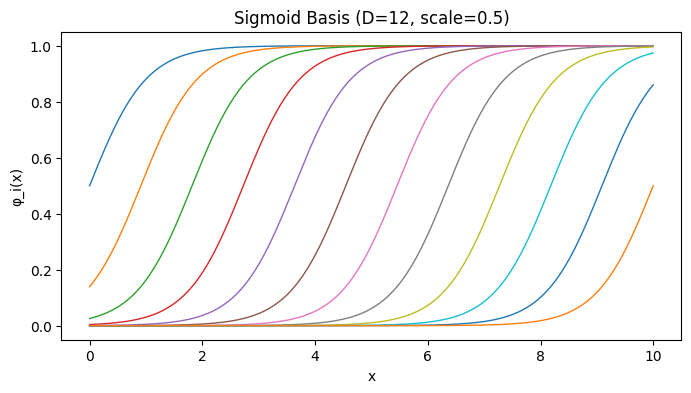

In [ ]:
S3_D = 12
S3_xs = np.linspace(0.0, 10.0, 400)
S3_Phi, S3_mus, S3_scale = sigmoid_design(S3_xs, D=S3_D, scale=None, alpha=0.6)

plt.figure(figsize=(8,4))
for i in range(S3_Phi.shape[1]):
    plt.plot(S3_xs, S3_Phi[:, i], linewidth=1)
plt.title(f"Sigmoid Basis (D={S3_D}, scale={S3_scale:.3g})")
plt.xlabel("x"); plt.ylabel("φ_i(x)")
plt.show()


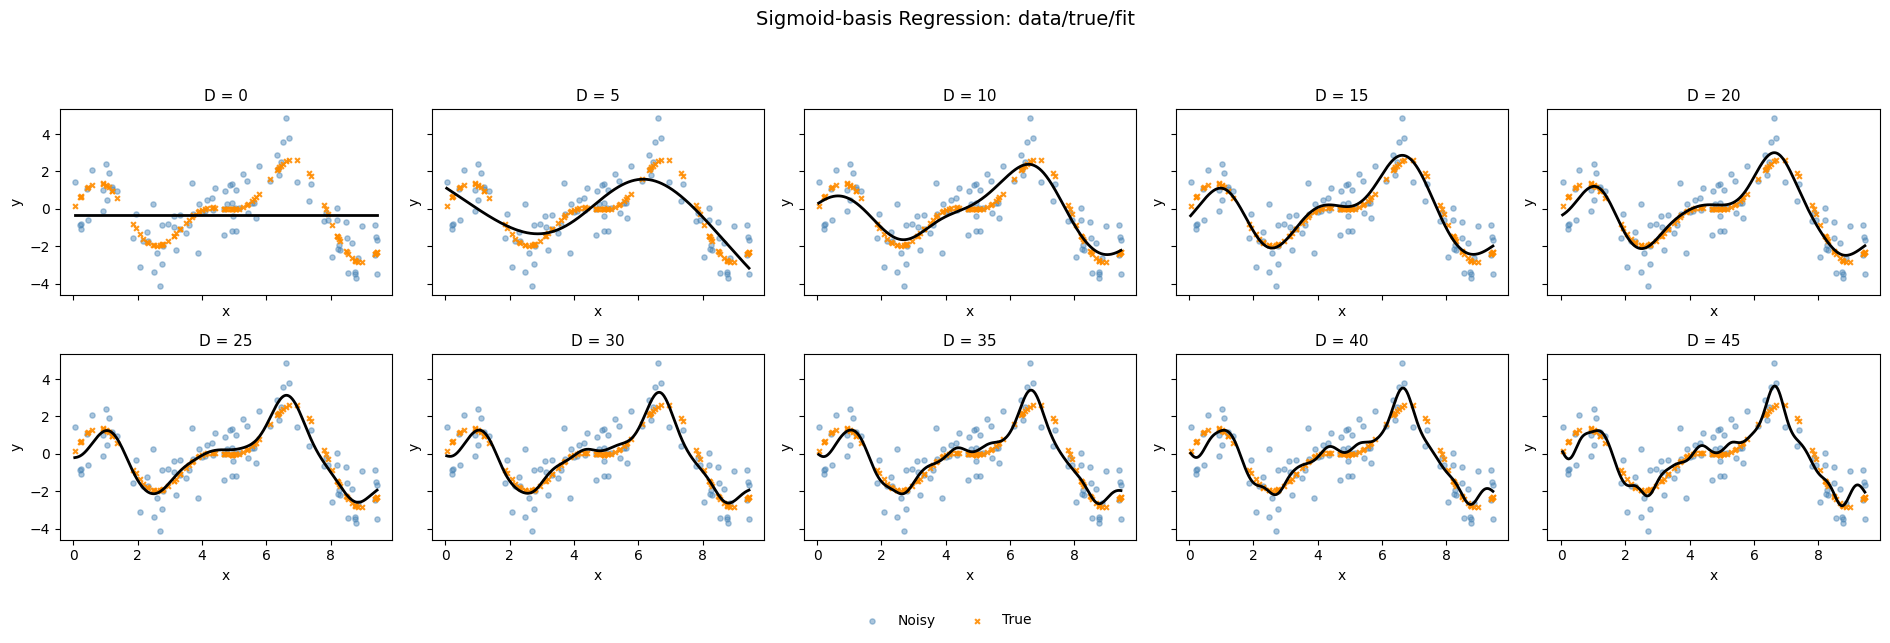

In [ ]:
rng_S4 = np.random.default_rng(500)
S4_n = 100
S4_X = rng_S4.uniform(0.0, 10.0, S4_n)
S4_y = f_true(S4_X) + rng_S4.normal(0.0, 1.0, S4_n)

S4_Ds = list(range(0, 46, 5))
S4_gd = GradientDescent(learning_rate=5e-2, max_iters=20000, epsilon=1e-7)

xs_dense = np.linspace(float(S4_X.min()), float(S4_X.max()), 600)
y_true_dense = f_true(xs_dense)
y_true_at_data = f_true(S4_X)

nD = len(S4_Ds); n_cols = 5; n_rows = int(np.ceil(nD / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.8*n_cols, 3.0*n_rows), sharex=True, sharey=True)
axes = np.asarray(axes).ravel()

for ax, D in zip(axes, S4_Ds):
    Phi_tr, _, used_scale = sigmoid_design(S4_X, D=D, scale=None, alpha=0.6)
    Phi_dx, _, _          = sigmoid_design(xs_dense, D=D, scale=used_scale, alpha=0.6)

    model = LinearRegression(add_bias=True)
    model.fit(Phi_tr, S4_y, S4_gd)
    y_fit = model.predict(Phi_dx)

    ax.scatter(S4_X, S4_y, s=14, alpha=0.45, label="Noisy", color="steelblue")
    ax.scatter(S4_X, y_true_at_data, s=12, alpha=0.9, marker='x', label="True", color="darkorange")
    ax.plot(xs_dense, y_fit, linewidth=2, color="black")
    ax.set_title(f"D = {D}", fontsize=11)
    ax.set_xlabel("x"); ax.set_ylabel("y")

for j in range(len(S4_Ds), len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False, fontsize=10, bbox_to_anchor=(0.5, -0.02))
fig.suptitle("Sigmoid-basis Regression: data/true/fit", fontsize=14, y=1.03)
plt.tight_layout(rect=[0, 0.05, 1, 0.98]); plt.show()


In [ ]:
rng_S5 = np.random.default_rng(9001)
S5_n = 100
S5_X = rng_S5.uniform(0.0, 10.0, S5_n)
S5_y = f_true(S5_X) + rng_S5.normal(0.0, 1.0, S5_n)

S5_k  = 10
S5_Ds = list(range(0, 46, 5))
S5_gd = GradientDescent(learning_rate=5e-2, max_iters=20000, epsilon=1e-7)

S5_rows = []
for D in S5_Ds:
    tr_sse, val_sse = [], []
    for tr_idx, val_idx in cross_validate(len(S5_X), S5_k):
        Xtr, Xval = S5_X[tr_idx], S5_X[val_idx]
        ytr, yval = S5_y[tr_idx], S5_y[val_idx]

        Phi_tr,  _, used_scale = sigmoid_design(Xtr,  D=D, scale=None,       alpha=0.6)
        Phi_val, _, _          = sigmoid_design(Xval, D=D, scale=used_scale, alpha=0.6)

        model = LinearRegression(add_bias=True)
        model.fit(Phi_tr, ytr, S5_gd)

        yhat_tr  = model.predict(Phi_tr)
        yhat_val = model.predict(Phi_val)
        tr_sse.append(sse(ytr,  yhat_tr))
        val_sse.append(sse(yval, yhat_val))

    tr_sse = np.array(tr_sse, dtype=float)
    val_sse = np.array(val_sse, dtype=float)
    mean_tr = float(tr_sse.mean())
    mean_val = float(val_sse.mean())
    sd_val  = float(np.std(val_sse, ddof=1))
    se_val  = sd_val / np.sqrt(S5_k)
    S5_rows.append((D, mean_tr, mean_val, sd_val, se_val))

S5_rows = sorted(S5_rows, key=lambda t: t[0])
hdr = f"{'D':>3}  {'SSE_train':>12}  {'SSE_val':>12}  {'±1 SE':>9}  {'±1 SD':>9}"
print(hdr); print("-"*len(hdr))
for D, m_tr, m_val, sd_val, se_val in S5_rows:
    print(f"{D:>3d}  {m_tr:12.2f}  {m_val:12.2f}  {se_val:9.2f}  {sd_val:9.2f}")

best_D, _, best_val, best_sd, best_se = min(S5_rows, key=lambda t: t[2])
print(f"\nBest D (min mean SSE_val): {best_D} | SSE_val = {best_val:.2f} (±{best_sd:.2f} SD, ±{best_se:.2f} SE)")
thr_1SE = best_val + best_se
eligible = [D for (D, _, m_val, _, _) in S5_rows if m_val <= thr_1SE]
one_se_D = min(eligible) if eligible else best_D
print(f"1-SE rule -> choose D = {one_se_D} (threshold = {thr_1SE:.2f})")


threshold_1SD = best_val + best_sd
eligible_1SD = [D for (D, _, m_val, _, _) in S5_rows if m_val <= threshold_1SD]
one_sd_D = min(eligible_1SD) if eligible_1SD else best_D
print(f"1-SD rule -> choose D = {one_sd_D} (threshold = {threshold_1SD:.2f})")


  D     SSE_train       SSE_val      ±1 SE      ±1 SD
-----------------------------------------------------
  0        359.27         41.06       3.76      11.89
  5        148.03         36.23       7.76      24.53
 10         85.87         32.39       5.87      18.56
 15         78.15         34.48       7.31      23.12
 20         76.71         36.72       8.53      26.99
 25         75.00         38.52       9.34      29.53
 30         72.89         39.92       9.84      31.13
 35         70.69         40.94      10.19      32.22
 40         68.32         41.73      10.43      32.99
 45         65.75         42.48      10.62      33.59

Best D (min mean SSE_val): 10 | SSE_val = 32.39 (±18.56 SD, ±5.87 SE)
1-SE rule -> choose D = 5 (threshold = 38.25)
1-SD rule -> choose D = 0 (threshold = 50.94)


# Task 2

> In this task, you will explore the bias-variance tradeoff by repeating the fitting process from Task 1 multiple times and analyzing the variation in the fitted models

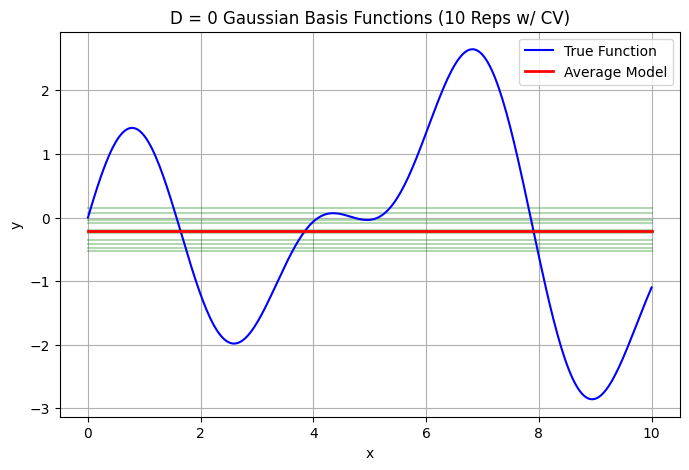

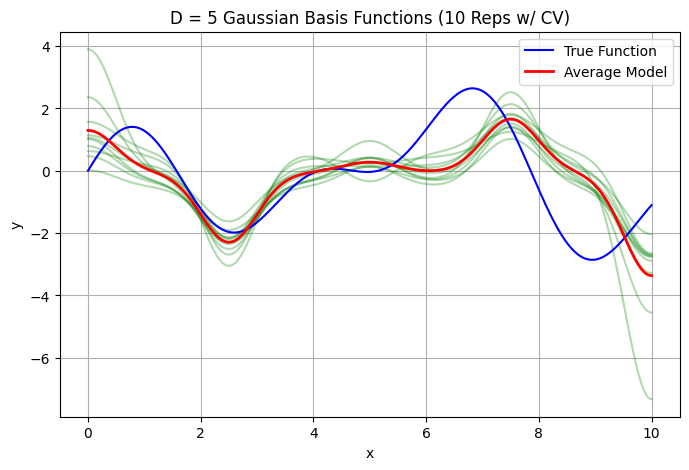

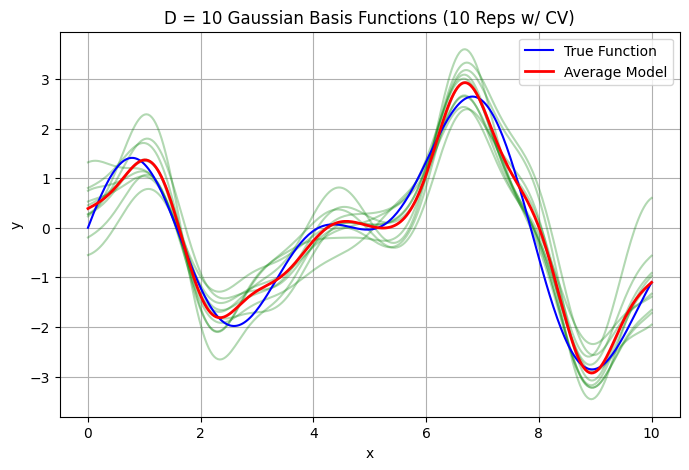

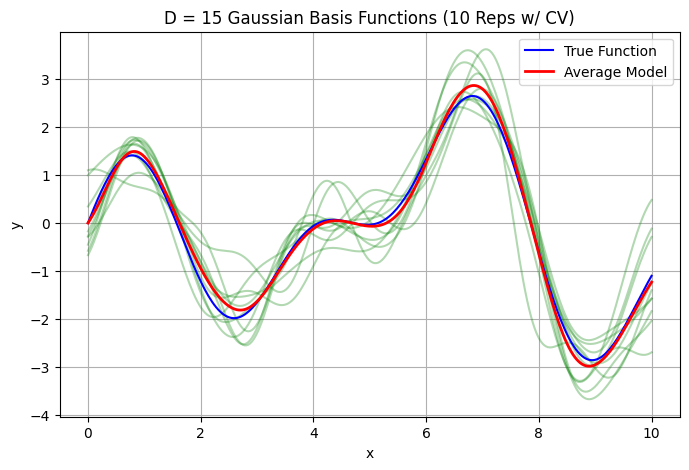

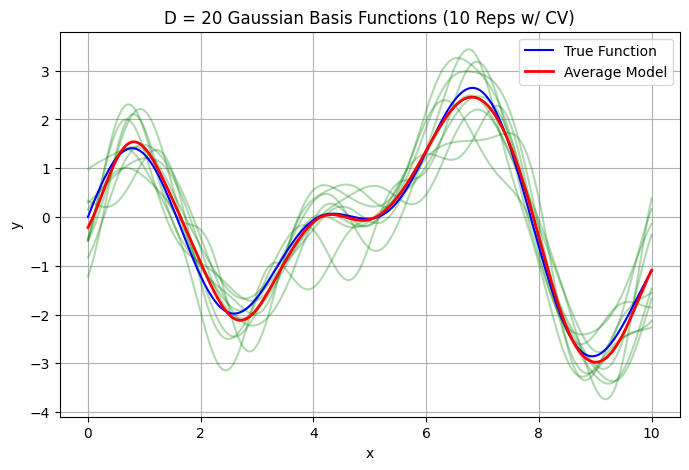

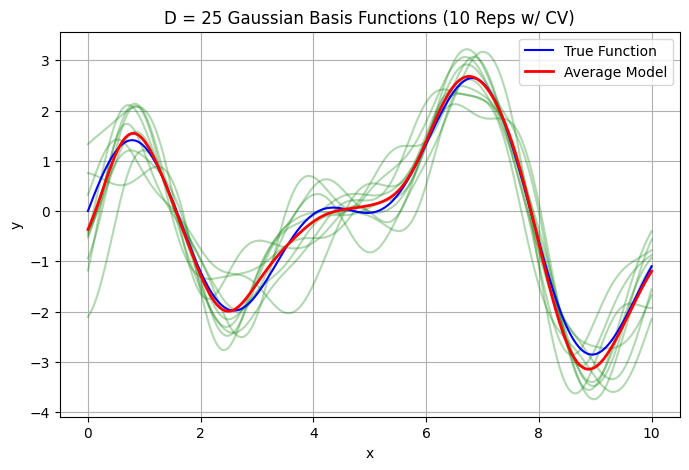

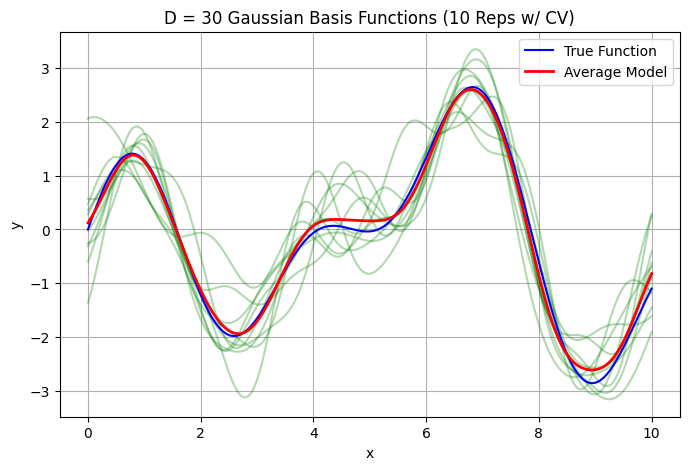

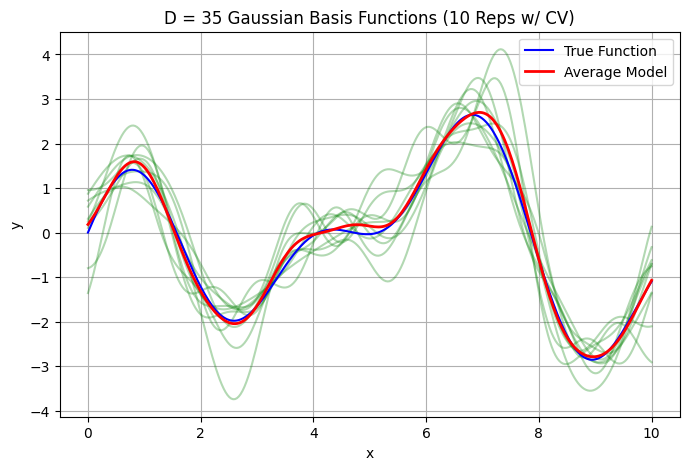

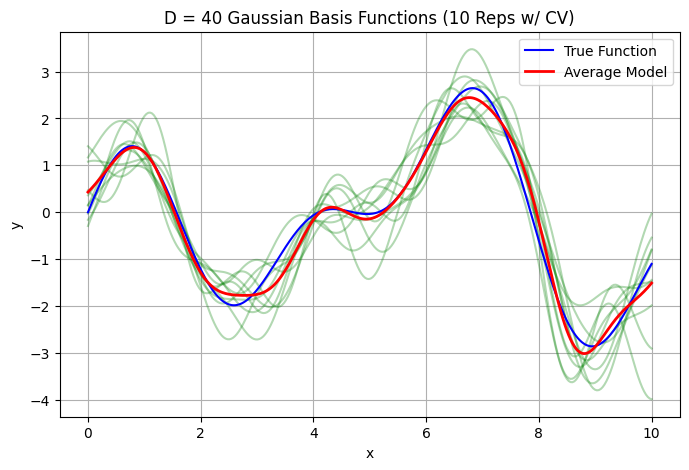

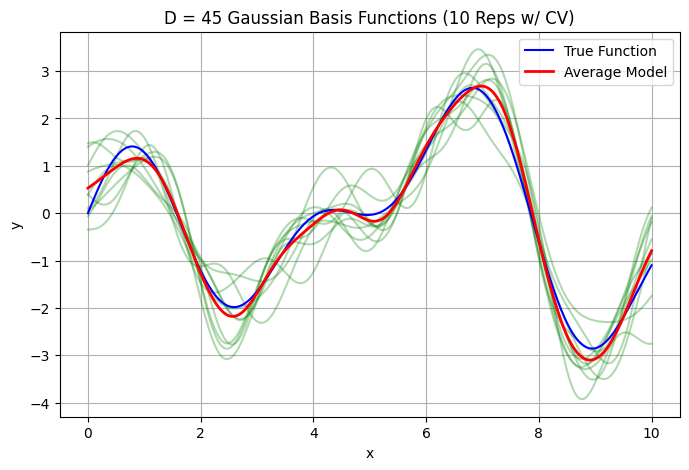

In [19]:
n_gaussian_basis = list(range(0, 46, 5))
k  = 10
gd = GradientDescent(learning_rate=5e-2, max_iters=20000, epsilon=1e-7)
avg_train_errors = []
avg_val_errors = []
x_plot = np.linspace(0, 10, 300)
true_y_plot = (np.log(x_plot + 1)) * np.cos(x_plot) + np.sin(2 * x_plot)
sigma = 0.7

for n in n_gaussian_basis:
  fitted_models = []
  train_errors = []
  val_errors = []

  for i in range(10):
    # re-sample the 100 data points
    x = np.random.uniform(0, 10, 100)
    epsilon = np.random.normal(0, 1, 100)
    y = (np.log(x + 1)) * np.cos(x) + np.sin(2 * x) + epsilon

    sse_tr_folds, sse_val_folds = [], []
    centers = gaussian_centers(0, 10, n)
    for tr_idx, val_idx in cross_validate(len(x), n_folds=k):
      xtr, xval = x[tr_idx], x[val_idx]
      ytr, yval = y[tr_idx], y[val_idx]

      Phi_tr, _ = gaussian_design(xtr,  D=n, sigma=sigma, centers=centers)
      Phi_val, _ = gaussian_design(xval, D=n, sigma=sigma, centers=centers)

      model = LinearRegression(add_bias=True)      # no regularization per spec
      model.fit(Phi_tr, ytr, gd)

      yhat_tr  = model.predict(Phi_tr)
      yhat_val = model.predict(Phi_val)

      sse_tr_folds.append(sse(ytr,  yhat_tr))
      sse_val_folds.append(sse(yval, yhat_val))

    train_errors.append(np.mean(sse_tr_folds))
    val_errors.append(np.mean(sse_val_folds))

    Phi_plot, _ = gaussian_design(x_plot, D=n, sigma=sigma, centers=centers)
    yhat_plot = model.predict(Phi_plot)
    fitted_models.append(yhat_plot)

  avg_train_errors.append(np.mean(train_errors))
  avg_val_errors.append(np.mean(val_errors))

  plt.figure(figsize=(8, 5))
  for yhat in fitted_models[:10]:  # Plot only one per rep (optional)
    plt.plot(x_plot, yhat, color='green', alpha=0.3)
  plt.plot(x_plot, true_y_plot, color='blue', label='True Function')
  plt.plot(x_plot, np.mean(fitted_models[:10], axis=0), color='red', label='Average Model', linewidth=2)
  plt.title(f'D = {n} Gaussian Basis Functions (10 Reps w/ CV)')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.grid(True)
  plt.show()



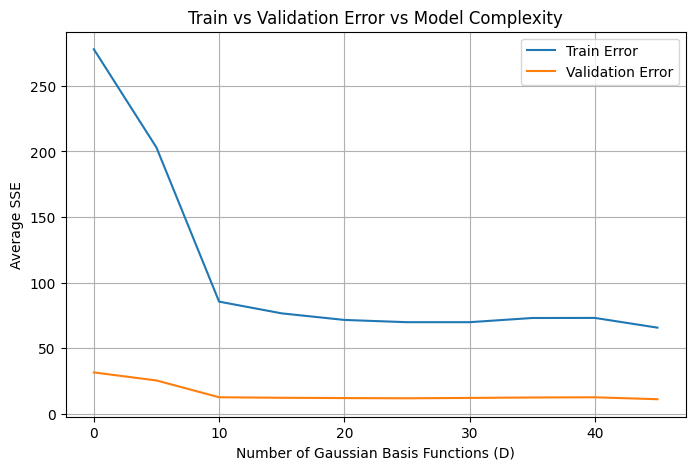

In [20]:
plt.figure(figsize=(8,5))
plt.plot(n_gaussian_basis, avg_train_errors, label="Train Error")
plt.plot(n_gaussian_basis, avg_val_errors, label="Validation Error")
plt.xlabel("Number of Gaussian Basis Functions (D)")
plt.ylabel("Average SSE")
plt.title("Train vs Validation Error vs Model Complexity")
plt.legend()
plt.grid(True)
plt.show()

# Task 3

> In this task, you will implement and apply both L1 (Lasso) and L2 (Ridge) regularization to a linear regression model and use 10-fold cross-validation to determine the optimal regularization strength (λ).

In [21]:
sigma_value = 1.0
num_folds = 10
N=20
D_value=45
noise_variance=1
num_datasets = 50
reg_list = np.logspace(-3, 1, 10)

In [22]:
def generate_dataset(N, noise_variance):
  x = np.random.uniform(0, 10, N)
  y = (np.log(x + 1)) * np.cos(x) + np.sin(2 * x)
  epsilon = np.random.normal(0, np.sqrt(noise_variance), N)
  y = y + epsilon
  return x,y

In [23]:
n_train = 16

In [24]:
def evaluation_regularization(type_reg, reg_list, x_train, y_train):

    optimizer = GradientDescent(learning_rate=.01, max_iters=20000, epsilon=1e-7, record_history=False)

    mean_train_errors = []
    mean_val_errors = []

    for lambda_value in reg_list:


        mean_validation_mse = 0
        mean_training_mse = 0

        for i, (train_index, validation_index) in enumerate(cross_validate(n_train, num_folds)):
          x_train_fold, x_validation_fold = x_train[train_index], x_train[validation_index]
          y_train_fold, y_validation_fold = y_train[train_index], y_train[validation_index]

          x_train_fold_gaussian, mus = gaussian_design(x_train_fold, D=D_value, sigma=sigma_value)
          Xv = np.asarray(x_validation_fold).reshape(-1, 1)
          diffs_val = Xv - mus[None, :]
          x_validation_fold_gaussian = np.exp(-(diffs_val**2) / (sigma_value**2))

          model = LinearRegression(type_reg=type_reg,lambda_reg=lambda_value)
          model.fit(x_train_fold_gaussian,y_train_fold, optimizer)
          y_train_pred = model.predict(x_train_fold_gaussian)
          y_validation_pred = model.predict(x_validation_fold_gaussian)

          train_mse = mean_squared_error(y_train_fold, y_train_pred)
          mean_training_mse += train_mse

          validation_mse = mean_squared_error(y_validation_fold, y_validation_pred)
          mean_validation_mse += validation_mse

        mean_training_mse /= num_folds
        mean_validation_mse /= num_folds

        mean_train_errors.append(mean_training_mse)
        mean_val_errors.append(mean_validation_mse)

    return mean_train_errors, mean_val_errors


In [25]:
def datasets_cross_evaluation(type_reg, reg_list, num_datasets):
  avg_train = np.zeros(len(reg_list), dtype=float)
  avg_val   = np.zeros(len(reg_list), dtype=float)

  for i in range(num_datasets):

    x,y = generate_dataset(N, noise_variance)
    num_instances = x.shape[0]
    n_test = num_instances // 5 # Get 20% for testing
    inds = np.random.permutation(num_instances)

    #seperate the test data
    x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
    x_train, y_train = x[inds[n_test:]], y[inds[n_test:]]

    #rest for training and validation
    n_train = num_instances - n_test

    mean_train_errors, mean_val_errors = evaluation_regularization(type_reg, reg_list, x_train, y_train)
    avg_train += np.array(mean_train_errors)
    avg_val   += np.array(mean_val_errors)

  avg_train /= num_datasets
  avg_val   /= num_datasets
  return avg_train, avg_val

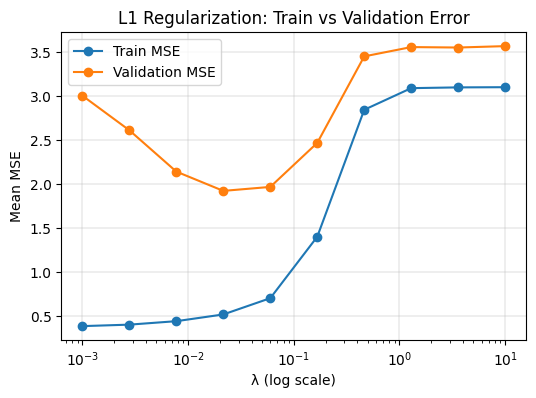

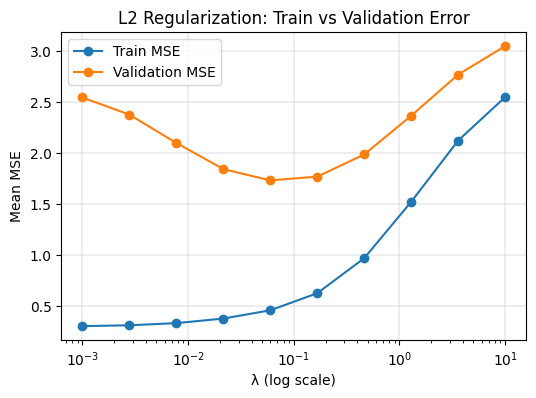

In [26]:
# PLOT TRAIN AND VALIDATION ERROR

# L1
mean_train_errors, mean_val_errors = datasets_cross_evaluation(L1, reg_list, num_datasets)
plt.figure(figsize=(6,4))
plt.plot(reg_list, mean_train_errors, marker='o', label='Train MSE')
plt.plot(reg_list, mean_val_errors, marker='o', label='Validation MSE')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('Mean MSE')
plt.title(f'L1 Regularization: Train vs Validation Error')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

# L2
mean_train_errors, mean_val_errors = datasets_cross_evaluation(L2, reg_list, num_datasets)
plt.figure(figsize=(6,4))
plt.plot(reg_list, mean_train_errors, marker='o', label='Train MSE')
plt.plot(reg_list, mean_val_errors, marker='o', label='Validation MSE')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('Mean MSE')
plt.title(f'L2 Regularization: Train vs Validation Error')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

In [27]:
def evaluation_bias_variance(type_reg, reg_list):
    xs_eval = np.linspace(0.0, 10.0, 200)
    Phi_eval, mus_eval = gaussian_design(xs_eval, D=D_value, sigma=sigma_value)
    y_true_eval = (np.log(xs_eval + 1)) * np.cos(xs_eval) + np.sin(2 * xs_eval)

    sum_preds   = [np.zeros(Phi_eval.shape[0]) for _ in range(len(reg_list))]
    sumsq_preds = [np.zeros(Phi_eval.shape[0]) for _ in range(len(reg_list))]

    optimizer = GradientDescent(learning_rate=.01, max_iters=20000, epsilon=1e-7)

    for i in range(num_datasets):
        x, y = generate_dataset(N, noise_variance)
        Phi_train, mus_train = gaussian_design(x, D=D_value, sigma=sigma_value)

        for j, lam in enumerate(reg_list):
            model = LinearRegression(add_bias=True, type_reg=type_reg, lambda_reg=lam)
            model.fit(Phi_train, y, optimizer)
            Phi_eval_cur, _ = gaussian_design(xs_eval, D=D_value, sigma=sigma_value, centers=mus_train)
            yhat_eval = model.predict(Phi_eval_cur).ravel()
            sum_preds[j]   += yhat_eval
            sumsq_preds[j] += yhat_eval ** 2

    bias2_list, var_list = [], []
    for j in range(len(reg_list)):
        mean_pred = sum_preds[j] / num_datasets
        var_pred  = (sumsq_preds[j] / num_datasets) - mean_pred**2
        bias2_list.append(np.mean((mean_pred - y_true_eval) ** 2))
        var_list.append(np.mean(var_pred))

    return np.array(bias2_list), np.array(var_list)


In [28]:
def datasets_cross_evaluation_bv(type_reg, reg_list, num_datasets):
    b2, v = evaluation_bias_variance(type_reg, reg_list)
    sum_bv = b2 + v
    test_error = sum_bv + noise_variance
    return b2, v, sum_bv, test_error

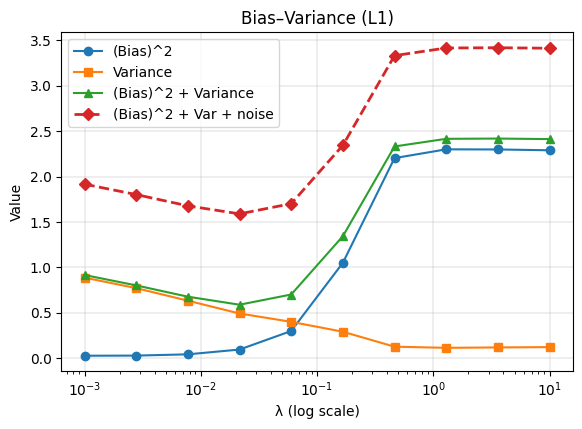

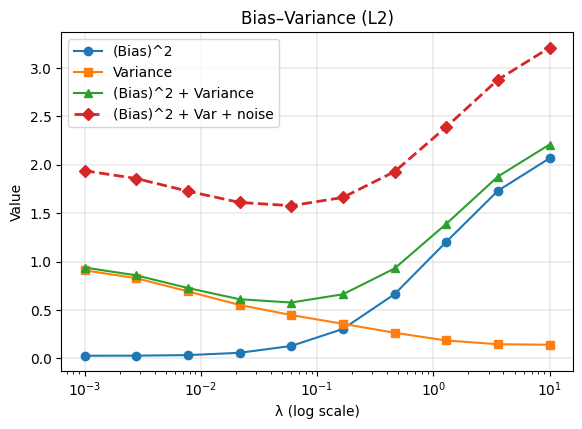

In [29]:
# L1
b2_L1, v_L1, sum_L1, test_L1 = datasets_cross_evaluation_bv('L1', reg_list, num_datasets)
plt.figure(figsize=(6.6, 4.4))
plt.plot(reg_list, b2_L1, marker='o', label='(Bias)^2')
plt.plot(reg_list, v_L1,  marker='s', label='Variance')
plt.plot(reg_list, sum_L1, marker='^', label='(Bias)^2 + Variance')
plt.plot(reg_list, test_L1, marker='D', linestyle='--', linewidth=2.0, label='(Bias)^2 + Var + noise')
plt.xscale('log'); plt.xlabel('λ (log scale)'); plt.ylabel('Value'); plt.title('Bias–Variance (L1)')
plt.legend(); plt.grid(True, linewidth=0.3); plt.show()

# L2
b2_L2, v_L2, sum_L2, test_L2 = datasets_cross_evaluation_bv('L2', reg_list, num_datasets)
plt.figure(figsize=(6.6, 4.4))
plt.plot(reg_list, b2_L2, marker='o', label='(Bias)^2')
plt.plot(reg_list, v_L2,  marker='s', label='Variance')
plt.plot(reg_list, sum_L2, marker='^', label='(Bias)^2 + Variance')
plt.plot(reg_list, test_L2, marker='D', linestyle='--', linewidth=2.0, label='(Bias)^2 + Var + noise')
plt.xscale('log'); plt.xlabel('λ (log scale)'); plt.ylabel('Value'); plt.title('Bias–Variance (L2)')
plt.legend(); plt.grid(True, linewidth=0.3); plt.show()


## Analysis of the results


According to the plots, for small $\lambda$ values (from $10^{-3}$ to around $10^{-2}$), the bias is low. At the same time, the variance is high, indicating that the model is too expressive and slightly overfits the training data. As $\lambda$ increases, the variance decreases and the bias increases, leading to a region where their sum and total error get to a minimum. For L1 (Lasso) regularization, which enforces stronger sparsity, the optimal $\lambda$ is smaller ($\approx 10^{-2}$ - $10^{-1}$). While, for L2 (Ridge) regularization, the optimal is when $\lambda$ $\approx 10^{-1}$ - $10^{0}$. Beyond these points, the bias gets bigger and the model underfits, as stronger regularization may simplify the model too much and reduce its ability to capture data variability in a general way.

## Selection of optimal value

to choose a specific optimal regularization strength value, it is possible to apply a "rule of thumb" that selects the simplest model within one standard deviation of the model with the lowest validation error. The simplest model means the one with lower variance; therefore, the optimal value is the largest $\lambda$ within one standard deviation of the minimum validation error.

In [30]:
def datasets_cross_evaluation_with_std(type_reg, reg_list, num_datasets):

    sum_train   = np.zeros(len(reg_list), dtype=float)
    sum_val     = np.zeros(len(reg_list), dtype=float)
    sumsq_train = np.zeros(len(reg_list), dtype=float)
    sumsq_val   = np.zeros(len(reg_list), dtype=float)

    for i in range(num_datasets):
        x, y = generate_dataset(N, noise_variance)
        num_instances = x.shape[0]
        n_test = num_instances // 5
        inds = np.random.permutation(num_instances)

        x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
        x_train, y_train = x[inds[n_test:]], y[inds[n_test:]]
        global n_train
        n_train = num_instances - n_test

        mean_train_errors, mean_val_errors = evaluation_regularization(type_reg, reg_list, x_train, y_train)

        mt = np.array(mean_train_errors, dtype=float)
        mv = np.array(mean_val_errors, dtype=float)

        sum_train   += mt
        sum_val     += mv
        sumsq_train += mt**2
        sumsq_val   += mv**2

    avg_train = sum_train / num_datasets
    avg_val   = sum_val   / num_datasets

    var_train = (sumsq_train / num_datasets) - (avg_train ** 2)
    var_val   = (sumsq_val   / num_datasets) - (avg_val   ** 2)

    std_train = np.sqrt(np.maximum(0.0, var_train))
    std_val   = np.sqrt(np.maximum(0.0, var_val))

    return avg_train, avg_val, std_train, std_val


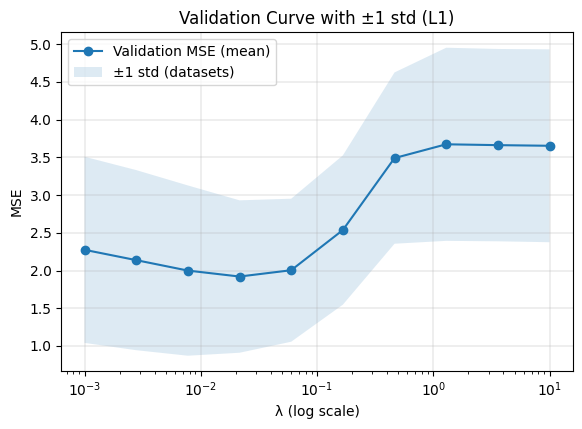

In [31]:
avg_tr_L1, avg_val_L1, std_tr_L1, std_val_L1 = datasets_cross_evaluation_with_std('L1', reg_list, num_datasets)

plt.figure(figsize=(6.6, 4.4))
plt.plot(reg_list, avg_val_L1, marker='o', label='Validation MSE (mean)')
plt.fill_between(reg_list, avg_val_L1 - std_val_L1, avg_val_L1 + std_val_L1, alpha=0.15, label='±1 std (datasets)')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('MSE')
plt.title('Validation Curve with ±1 std (L1)')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


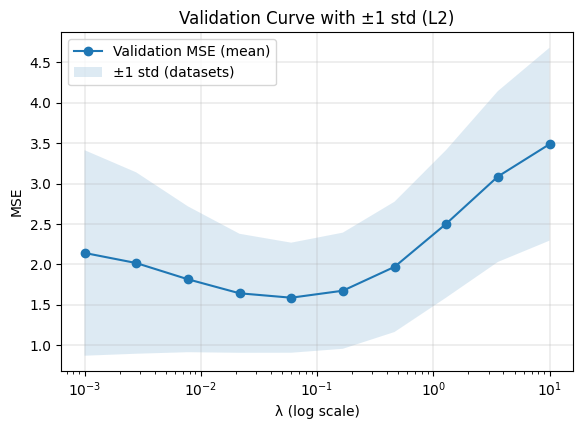

In [32]:
avg_tr_L2, avg_val_L2, std_tr_L2, std_val_L2 = datasets_cross_evaluation_with_std('L2', reg_list, num_datasets)

plt.figure(figsize=(6.6, 4.4))
plt.plot(reg_list, avg_val_L2, marker='o', label='Validation MSE (mean)')
plt.fill_between(reg_list, avg_val_L2 - std_val_L2, avg_val_L2 + std_val_L2, alpha=0.15, label='±1 std (datasets)')
plt.xscale('log'); plt.xlabel('λ (log scale)'); plt.ylabel('MSE'); plt.title('Validation Curve with ±1 std (L2)')
plt.legend(); plt.grid(True, linewidth=0.3); plt.show()


λ_min  = 0.0215
λ_1se  = 0.1668


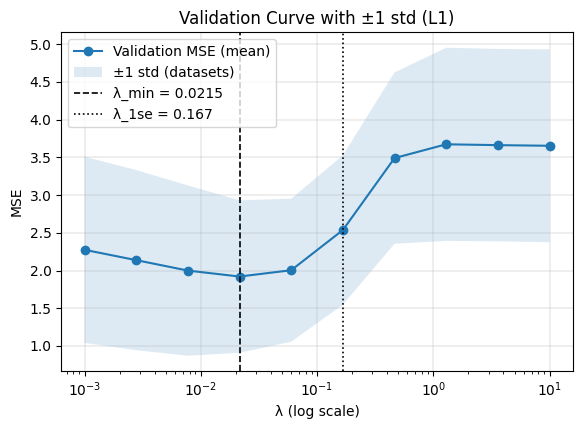

In [33]:
idx_min = int(np.argmin(avg_val_L1))
lam_min = reg_list[idx_min]

band_std = std_val_L1[idx_min]
threshold = avg_val_L1[idx_min] + band_std

ok = np.where(avg_val_L1 <= threshold)[0]
idx_1se = int(ok[-1])
lam_1se = reg_list[idx_1se]

print(f"λ_min  = {lam_min:.4f}")
print(f"λ_1se  = {lam_1se:.4f}")

plt.figure(figsize=(6.6, 4.4))
plt.plot(reg_list, avg_val_L1, marker='o', label='Validation MSE (mean)')
plt.fill_between(reg_list,
                 avg_val_L1 - std_val_L1,
                 avg_val_L1 + std_val_L1,
                 alpha=0.15, label='±1 std (datasets)')

plt.axvline(lam_min, color='black', linestyle='--', linewidth=1.2, label=f'λ_min = {lam_min:.3g}')
plt.axvline(lam_1se, color='black', linestyle=':',  linewidth=1.2, label=f'λ_1se = {lam_1se:.3g}')

plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('MSE')
plt.title('Validation Curve with ±1 std (L1)')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

λ_min  = 0.0599
λ_1se  = 0.4642


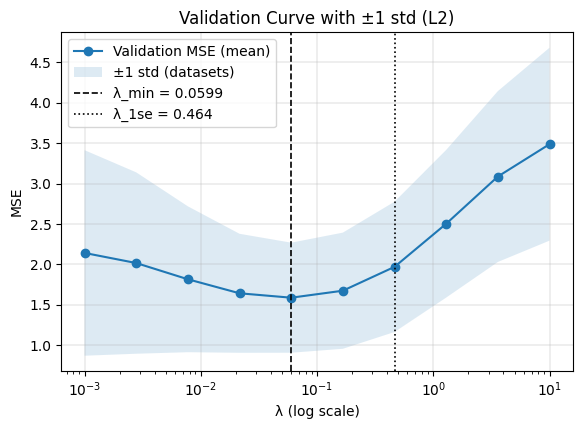

In [34]:
idx_min = int(np.argmin(avg_val_L2))
lam_min = reg_list[idx_min]

band_std = std_val_L2[idx_min]
threshold = avg_val_L2[idx_min] + band_std

ok = np.where(avg_val_L2 <= threshold)[0]
idx_1se = int(ok[-1])
lam_1se = reg_list[idx_1se]

print(f"λ_min  = {lam_min:.4f}")
print(f"λ_1se  = {lam_1se:.4f}")

plt.figure(figsize=(6.6, 4.4))
plt.plot(reg_list, avg_val_L2, marker='o', label='Validation MSE (mean)')
plt.fill_between(reg_list, avg_val_L2 - std_val_L2, avg_val_L2 + std_val_L2, alpha=0.15, label='±1 std (datasets)')

plt.axvline(lam_min, color='black', linestyle='--', linewidth=1.2, label=f'λ_min = {lam_min:.3g}')
plt.axvline(lam_1se, color='black', linestyle=':',  linewidth=1.2, label=f'λ_1se = {lam_1se:.3g}')

plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('MSE')
plt.title('Validation Curve with ±1 std (L2)')
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()


In the first plot, the model with the lowest validation error for L1 regularization is the one which $\lambda$ is 0.0215 for L1. Following the rule of thumb, the optimal $\lambda$ is \textbf{0.167}, as it is the simplest model (i.e., higher regularization strength) within one standard deviation of the minimum validation error. For L2, as observed in the second plot, the lowest $\lambda$ value is 0.0599, and the optimal value is \textbf{1.29}.

# Task 4

> In this task, you will explore the effects of L1 and L2 regularization on linear regression models by fitting models with varying regularization strengths, plotting the corresponding loss contours, and visualizing the paths taken by gradient descent.

plot contour

In [35]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Generate 30 data points from y = −3x + 8 + 2ϵ

In [36]:

np.random.seed(42)

x = np.random.uniform(0, 10, 30)
epsilon = np.random.normal(0, 1, 30)

y = -3 * x + 8 + 2 * epsilon

Plot loss function L1

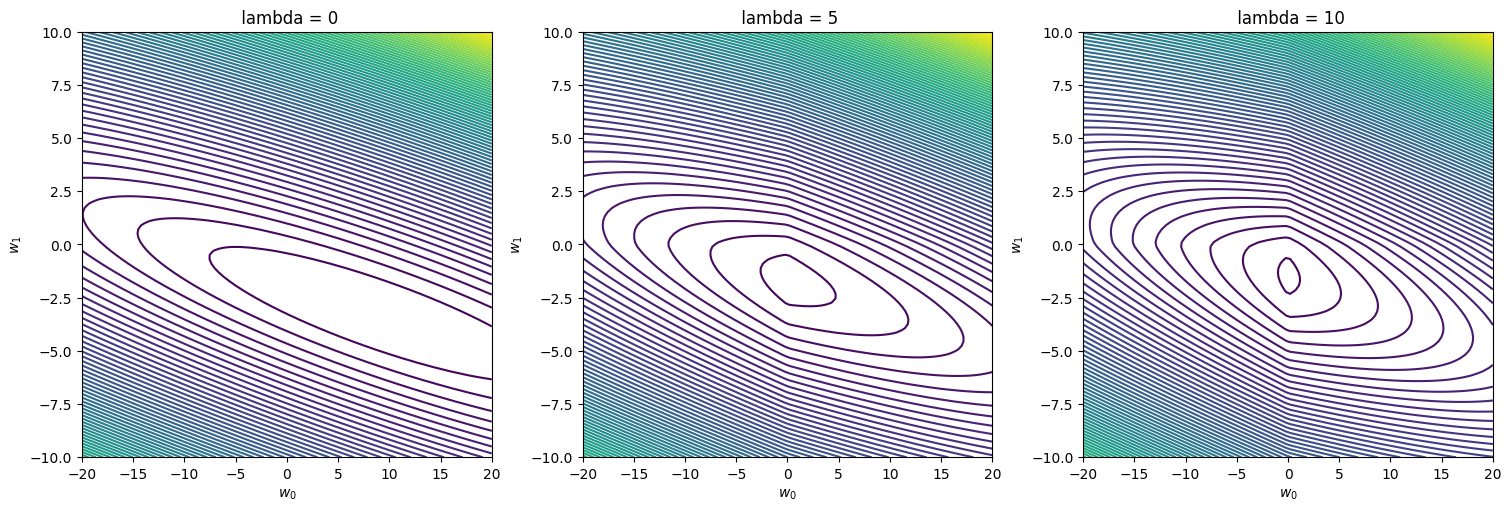

In [37]:
l1_cost = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.sum(np.abs(w))
reg_list = [0, 5, 10]
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(15, 5))

for i, reg_coef in enumerate(reg_list):
  optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=True)
  model = LinearRegression(optimizer, type_reg=L1, lambda_reg=reg_coef)
  model.fit(x,y, optimizer)
  current_cost = lambda w: l1_cost(w, reg_coef)
  plot_contour(current_cost, [-20,20], [-10,10], 100, axes[i])
  axes[i].set_xlabel(r'$w_0$')
  axes[i].set_ylabel(r'$w_1$')
  axes[i].set_title(f' lambda = {reg_coef}')
plt.show()

weight trajectory l1

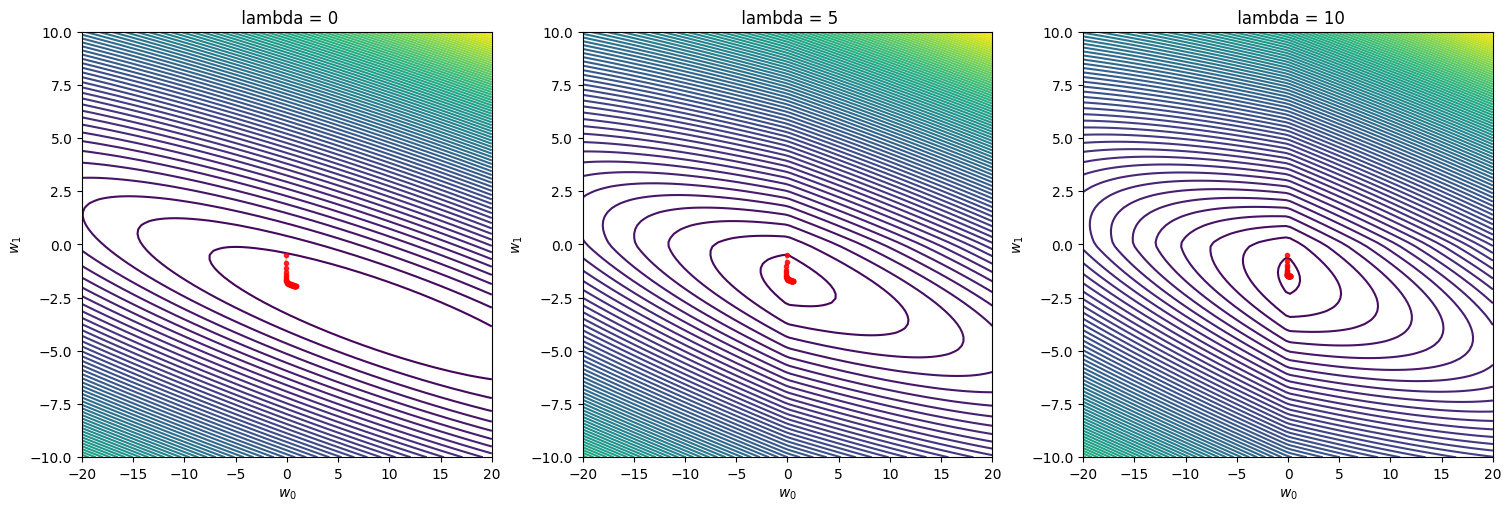

In [38]:
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(15, 5))
for i, reg_coef in enumerate(reg_list):
    optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=True)
    model = LinearRegression(optimizer, type_reg=L1, lambda_reg=reg_coef)
    model.fit(x,y, optimizer)
    current_cost = lambda w: l1_cost(w, reg_coef)
    plot_contour(current_cost, [-20,20], [-10,10], 100, axes[i])
    w_hist = np.vstack(optimizer.w_history)# T x 2
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f' lambda = {reg_coef}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-10,10])
plt.show()

 Plot loss function L2

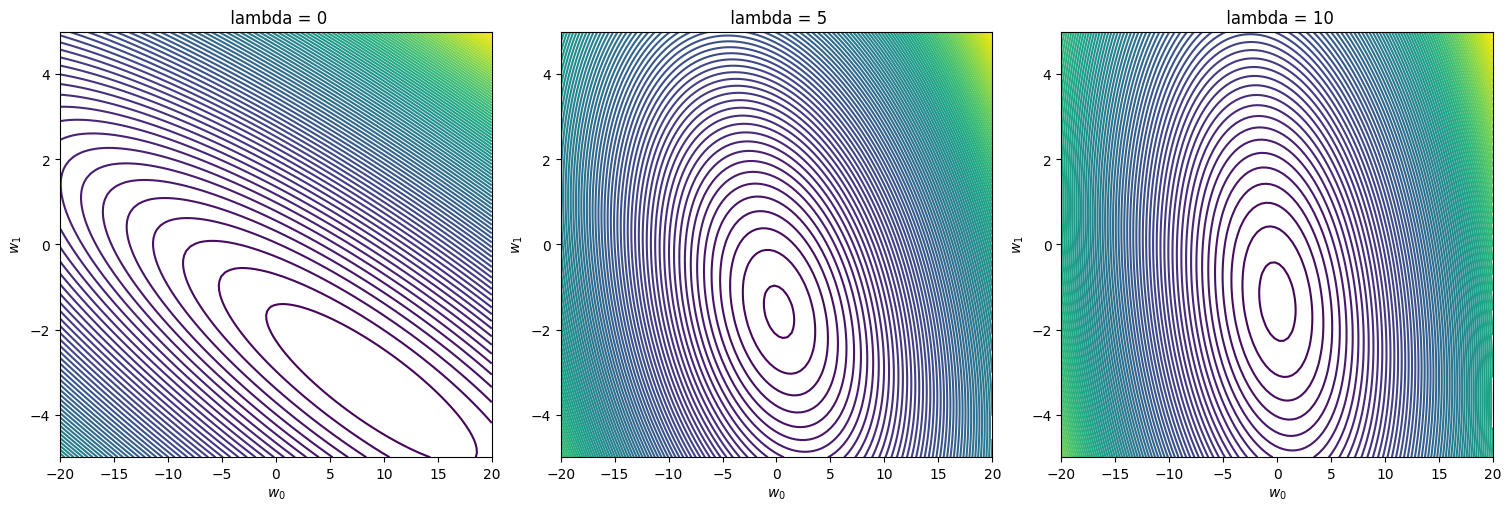

In [39]:
l2_cost = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.dot(w,w)/2
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(15, 5))

for i, reg_coef in enumerate(reg_list):
  optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=True)
  model = LinearRegression(optimizer, type_reg=L2, lambda_reg=reg_coef)
  model.fit(x,y, optimizer)
  current_cost = lambda w: l2_cost(w, reg_coef)
  plot_contour(current_cost, [-20,20], [-5,5], 100, axes[i])
  axes[i].set_xlabel(r'$w_0$')
  axes[i].set_ylabel(r'$w_1$')
  axes[i].set_title(f' lambda = {reg_coef}')
plt.show()

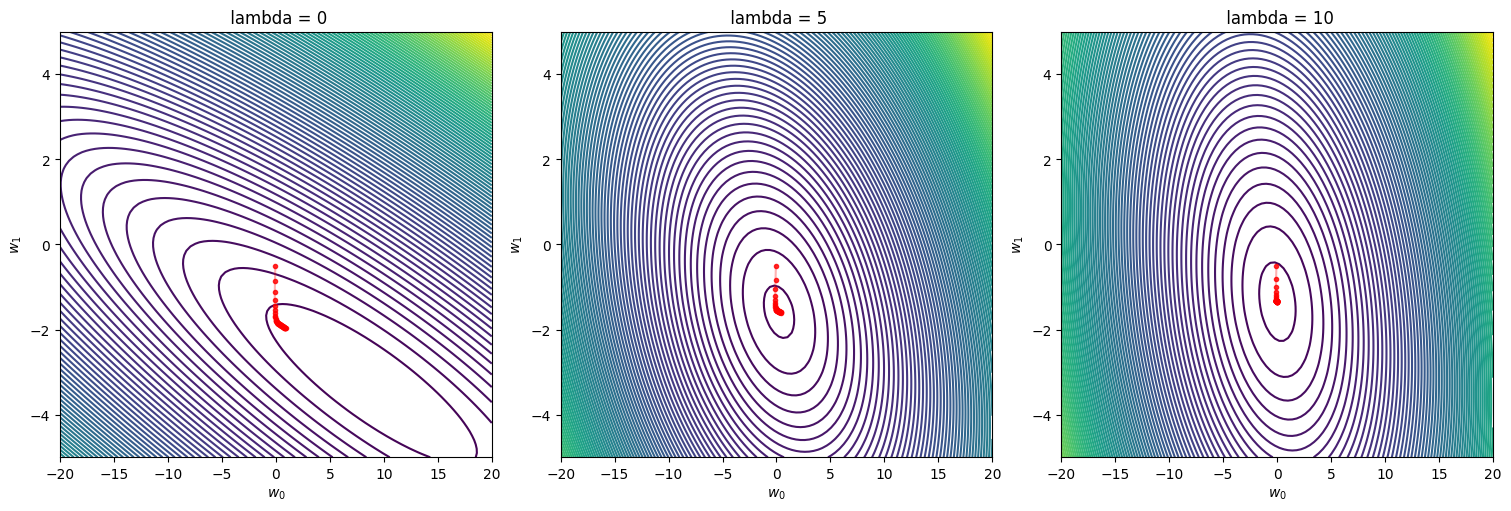

In [40]:
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(15, 5))
for i, reg_coef in enumerate(reg_list):
    optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=True)
    model = LinearRegression(optimizer, type_reg=L2, lambda_reg=reg_coef)
    model.fit(x,y, optimizer)
    current_cost = lambda w: l2_cost(w, reg_coef)
    plot_contour(current_cost, [-20,20], [-5,5], 100, axes[i])
    w_hist = np.vstack(optimizer.w_history)# T x 2
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f' lambda = {reg_coef}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
plt.show()